In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization,Dropout,Activation,Flatten
from keras.models import Model,Sequential,load_model
from keras.activations import relu,sigmoid
from keras import backend as K
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [ ]:
def init_model(input_shape):
  n_hidden_1, n_hidden_2, n_hidden_3 = 32, 8, 8
  convkernel = (3, 3)  # convolution kernel
  poolkernel = (2, 2)  # pooling kernel
  input_img = Input(shape=input_shape)
  x = Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(input_img)
  x = MaxPooling2D(poolkernel, padding='same')(x)
  x = Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
  x = MaxPooling2D(poolkernel, padding='same')(x)
  x = Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
  encoded = MaxPooling2D(poolkernel, padding='same')(x)

  x = Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(encoded)
  x = UpSampling2D(poolkernel)(x)
  x = Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
  x = UpSampling2D(poolkernel)(x)
  x = Conv2D(n_hidden_1, convkernel, activation='relu',padding='same')(x)
  x = UpSampling2D(poolkernel)(x)
  decoded = Conv2D(input_shape[2], convkernel, activation='sigmoid', padding='same')(x)
  model = Model(input_img, decoded)
  model.compile(loss="mean_squared_error",optimizer="adam",metrics=['accuracy'])
  return model

In [ ]:
INPUT_SHAPE = (256,256,1)
DIR_BASE_PATH = "/content/drive/My Drive/Avantari/dataset/dataset"

In [ ]:
model = init_model(INPUT_SHAPE)

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       2312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)        

In [ ]:
data = os.listdir(DIR_BASE_PATH)

In [ ]:
def preprocess_images(arr,DIR_BASE_PATH):
  features = []
  for i in arr:
    try:
      img = load_img(DIR_BASE_PATH+"/"+i,target_size=(256,256),color_mode='grayscale')
      img = img_to_array(img)
      img = img/255.0
      image = np.expand_dims(img, axis=0)
      features.append(image)
    except:
      pass
  x = np.vstack(features)
  return x

In [ ]:
train = preprocess_images(data[:4000],DIR_BASE_PATH)

In [ ]:
train.shape

(4000, 256, 256, 1)

In [ ]:
test = preprocess_images(data[4000:],DIR_BASE_PATH)

In [ ]:
checkpointer = ModelCheckpoint(filepath='avantari-sobel-attempt2-gray-256.hdf5',
                               verbose=1,save_best_only=True)
history = model.fit(train, train,
                    batch_size=32,
                    epochs=20,
                    verbose=1,
                    validation_data=(test,test),
                    callbacks=[checkpointer],
                    shuffle=True)

Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.0024
Epoch 00001: val_loss improved from inf to 0.01115, saving model to avantari-sobel-attempt2-gray-256.hdf5
125/125 [==============================] - 11s 87ms/step - loss: 0.0189 - accuracy: 0.0024 - val_loss: 0.0112 - val_accuracy: 0.0026
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.0025
Epoch 00002: val_loss improved from 0.01115 to 0.00944, saving model to avantari-sobel-attempt2-gray-256.hdf5
125/125 [==============================] - 11s 86ms/step - loss: 0.0103 - accuracy: 0.0025 - val_loss: 0.0094 - val_accuracy: 0.0026
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.0025
Epoch 00003: val_loss improved from 0.00944 to 0.00854, saving model to avantari-sobel-attempt2-gray-256.hdf5
125/125 [==============================] - 11s 87ms/step - loss: 0.0092 - accuracy: 0.0025 - val_loss: 0.0085 - val_accu

In [ ]:
res = model.predict(test[:10])

In [ ]:
def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        img = np.reshape(orig[i],orig[i].shape[:2])
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        img = np.reshape(dec[i],dec[i].shape[:2])
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

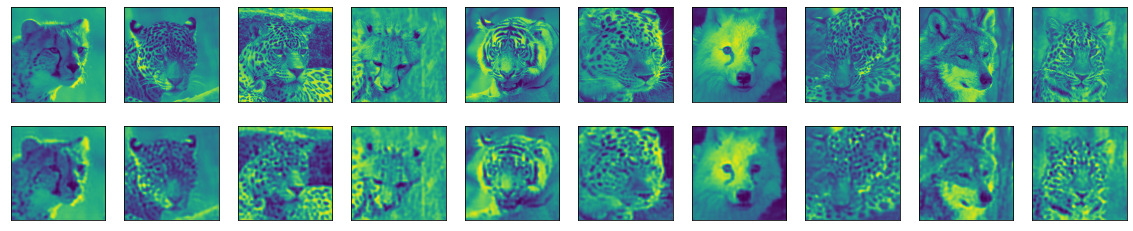

In [ ]:
showOrigDec(test[:10],res)

In [ ]:

# Create the encoder model
model = load_model("/content/avantari-sobel-attempt2-gray-256.hdf5")
encoded_model = Model(inputs=model.input,outputs=model.get_layer("max_pooling2d_2").output)
final = Sequential()
final.add(encoded_model)
final.add(Flatten())
final.compile(loss="mean_squared_error",optimizer='adam')

In [ ]:
final.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_5 (Functional)    (None, 32, 32, 8)         3216      
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
Total params: 3,216
Trainable params: 3,216
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def preprocess_images_for_kmeans(arr,DIR_BASE_PATH,pre_model):
  features = []
  for i in arr:
    try:
      img = load_img(DIR_BASE_PATH+"/"+i,target_size=(256,256),color_mode='grayscale')
      img = img_to_array(img)
      img = img/255.0
      image = np.expand_dims(img, axis=0)
      features.append(image)
    except:
      pass
  x = np.vstack(features)
  x = pre_model.predict(x)
  return x

In [ ]:
len(data)

4738

In [ ]:
train_kmeans = preprocess_images_for_kmeans(data,DIR_BASE_PATH,final)

In [ ]:
train_kmeans.shape

(4738, 8192)

In [ ]:
!pip install faiss-gpu

     |████████████████████████████████| 35.5MB 81kB/s 


In [ ]:
import faiss

In [ ]:
mat = faiss.PCAMatrix(d_in=8192,d_out=256,eigen_power=0.5)

In [ ]:
train_kmeans  = train_kmeans.astype('float32')

In [ ]:
mat.train(train_kmeans)

In [ ]:
x_pca = mat.apply_py(train_kmeans)

In [ ]:
import numpy as np
  
norm = np.linalg.norm(x_pca, axis=1)
x_l2 = x_pca / norm[:, np.newaxis]

In [ ]:
x_l2.shape

(4738, 256)

In [ ]:

from sklearn.cluster import KMeans
cost =[]
k = []
for i in range(1,10):
    KM = KMeans(n_clusters = i,  random_state=0) 
    KM.fit(x_l2)
    # calculates squared error 
    # for the clustered points
    cost.append(KM.inertia_)
    k.append(i)

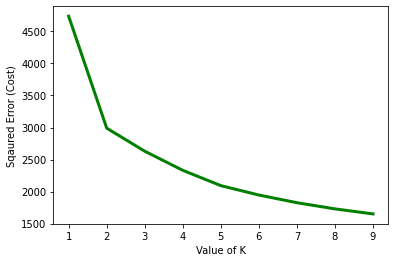

In [ ]:
import matplotlib.pyplot as plt
# plot the cost against K values 
plt.plot(range(1,10), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)")
plt.show() # clear the plot 

In [ ]:
from sklearn.cluster import KMeans
#initalize KMeans 
KM = KMeans(n_clusters = 5,  random_state=0)
#fit our features to Kmeans
KM.fit(x_l2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
# this will store key as cluster and  value as respective 
# indexes of our Imagelist in dictionary
d = {i: np.where(KM.labels_ == i) for i in range(KM.n_clusters)}

In [ ]:
# storing all the values of above d in list
all=[]
for i in range(KM.n_clusters):
    all.append(list(d[i][0]))

In [ ]:
 def show_imgs(Images,base_path,clus_index,clus):
    plt.figure(figsize=(15,15))
    k = 0
    for i in range(0,3):
        for j in range(0,10):
            p = base_path + "/"+Images[clus_index[k]]
            image = load_img(p, target_size=(224, 224))
            plt.title(clus)
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(image)
            k = k+1
    plt.show()

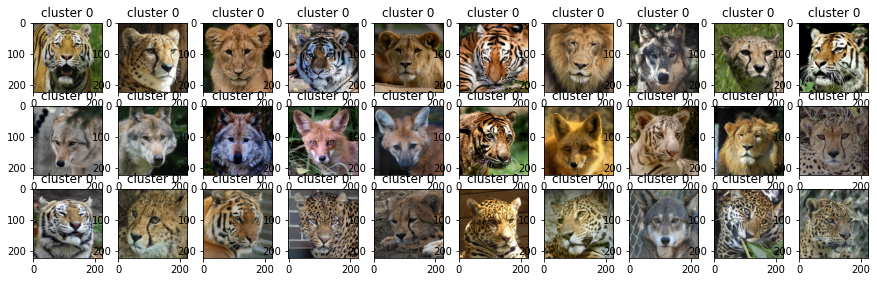

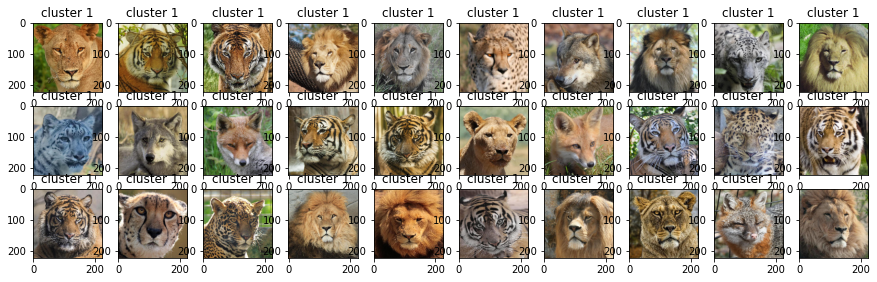

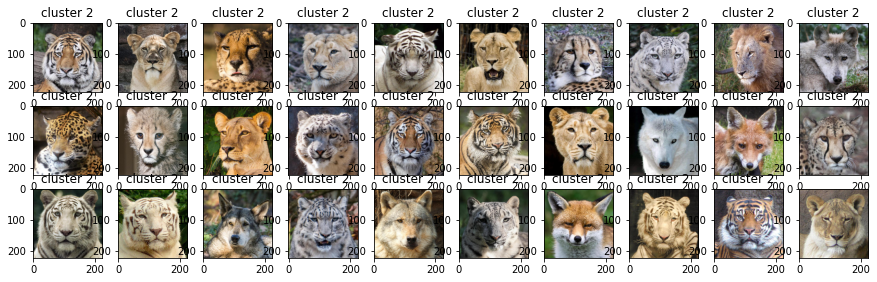

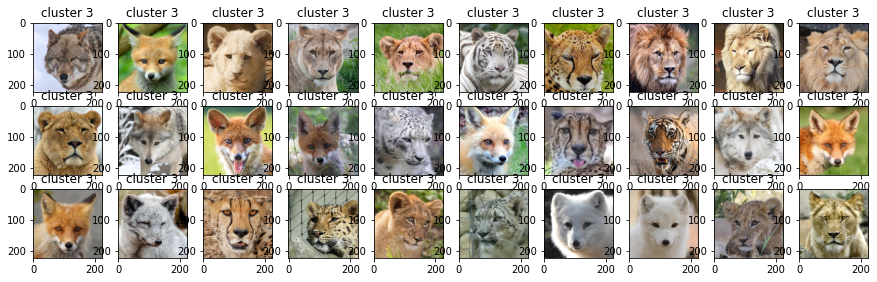

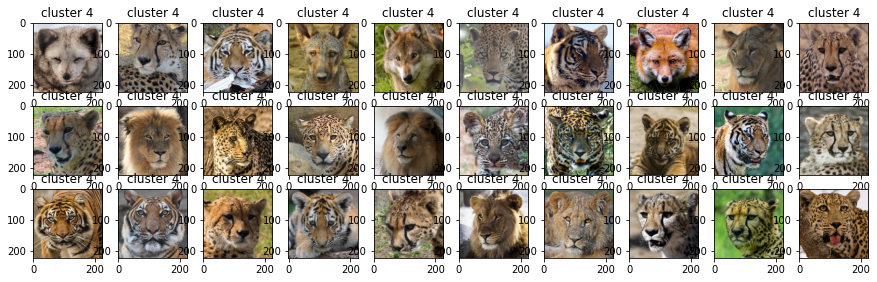

In [ ]:
k=0
for i in all:
  show_imgs(data,DIR_BASE_PATH,i,"cluster "+str(k))
  k=k+1